# Constructing our Minimum-Covariance Portfolios

We will be constructing our portfolios by selecting the assets which have the lowest correlations between each other. We will rebalance semi-annually based on these selections, and at each rebalance, ensure that our portfolio is split among the two geographies 50/50 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Preprocessing

In [2]:
# Remove 1st line since they are pct changes, therefore have
# NaNs in the first row
rets = pd.read_csv("data/returns.csv")[1:]

# Reindex to date
rets.index = pd.to_datetime(rets['Date'])
del rets['Date']

# Delete any outliers
rets[rets > 1] = 0
rets[rets < -1] = 0

In [3]:
# read the risk free rate
riskfree = pd.read_csv("data/3mTbill.csv")
riskfree['Date'] = pd.to_datetime(riskfree['Date'])

# match the date
riskfree = riskfree[riskfree['Date'].isin(rets.index.values)].set_index('Date')

# daily risk free
riskfree = ((1 + riskfree/100).pow(1/252)-1)

In [4]:
# benchmark index (MSCI ACWI Index)
benchmark = pd.read_csv("data/benchmark.csv")
benchmark['Date'] = pd.to_datetime(benchmark['Date'])

# calculate returns
benchmark['return'] = benchmark['Adj_Close'].pct_change()

# match the date
benchmark = benchmark[benchmark['Date'].isin(rets.index.values)].set_index('Date')

# calculate excess returns
rf_bm = riskfree[riskfree.index.isin(benchmark.index.values)]
benchmark_ret = benchmark['return']
benchmark_excess = benchmark['return'].subtract(rf_bm['RFR'], axis=0)

In [5]:
# Create a list of semiannual dates to split on
rets_bt = rets[rets.index <= '2016-02-28']
dates_to_split = pd.date_range(rets_bt.index[0], rets_bt.index[-1], freq='M')

# Split on these dates
semiannual_bt = {}

for i in range(len(dates_to_split)-1):
    semiannual_bt[i] = rets_bt[dates_to_split[i]:dates_to_split[i+1]]

rets_p = rets[rets.index >= '2016-02-28']
dates_to_split = pd.date_range(rets_p.index[0], rets_p.index[-1], freq='M')

# Split on these dates
semiannual_p = {}

for i in range(len(dates_to_split)-1):
    #print(dates_to_split[i+1])
    semiannual_p[i] = rets_p[dates_to_split[i]:dates_to_split[i+1]]

# Lowest correlation Search

In [6]:
top10_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs =  ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top10_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top15_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_bt[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]

top20_bt = {}
for i in range(1,len(semiannual_bt)):
    corrs = ((1+semiannual_bt[i-1]).cumprod()-1).iloc[-1]
    
    top20_bt[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_bt[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

top10_p = {}
for i in range(1,len(semiannual_p)):
    corrs =  ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top10_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:10]
    top10_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:10]

top15_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top15_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:15]
    top15_p[i] += [x for x in corrs.sort_values(ascending = False,axis=0).index if "CAN_" in x][:15]
    
top20_p = {}
for i in range(1,len(semiannual_p)):
    corrs = ((1+semiannual_p[i-1]).cumprod()-1).iloc[-1]
    
    top20_p[i] = [x for x in corrs.sort_values(ascending = False,axis=0).index if "USA_" in x][:20]
    top20_p[i] += [x for x in corrs.sort_values(ascending = False, axis=0).index if "CAN_" in x][:20]

# Portfolio weight optimization -- Risk Parity and Sharpe Ratio Maximization results Compare with Equally-weighted & Risk metrics, Cutoff calibration

In [7]:
# import modules 

import warnings
warnings.filterwarnings('ignore')

import portfolio_optimizer
import Risk_analytics

from importlib import reload
reload(portfolio_optimizer)
reload(Risk_analytics)

from portfolio_optimizer import portfolio_optimizer

In [8]:
# Risk mapping Parameter
VaRcutoff = {'VaR95':5000,'VaR99':5800,'CVaR95':5700,'CVaR99':5400}

In [9]:
# Benchmark PnL
k = benchmark_ret
benchmark_pnl = pd.DataFrame()
benchmark_pnl['return'] = k
benchmark_pnl['capital'] = 100000
dates_to_split = pd.date_range(rets.index[0], rets.index[-1], freq='6M')
for i in range(len(dates_to_split)-1):
    benchmark_pnl.loc[dates_to_split[i]:dates_to_split[i+1],'capital'] = 100000+ (i+1)*10000
benchmark_pnl.loc[dates_to_split[len(dates_to_split)-1]:,'capital']=  100000+ len(dates_to_split)*10000
benchmark_pnl['PnL'] = benchmark_pnl['return']*benchmark_pnl['capital']

benchmark_pnl_bt = benchmark_pnl[benchmark_pnl.index <= '03/31/2016']
benchmark_pnl_p = benchmark_pnl[benchmark_pnl.index >= '03/31/2016']

# Backtesting results - without options

10 cutoff ETFs

In [10]:
opt10_bt = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_bt.portfolio_simulator(100000, riskfree, top10_bt, 10, VaRcutoff, 'Sharpe ratio maximization', 0)

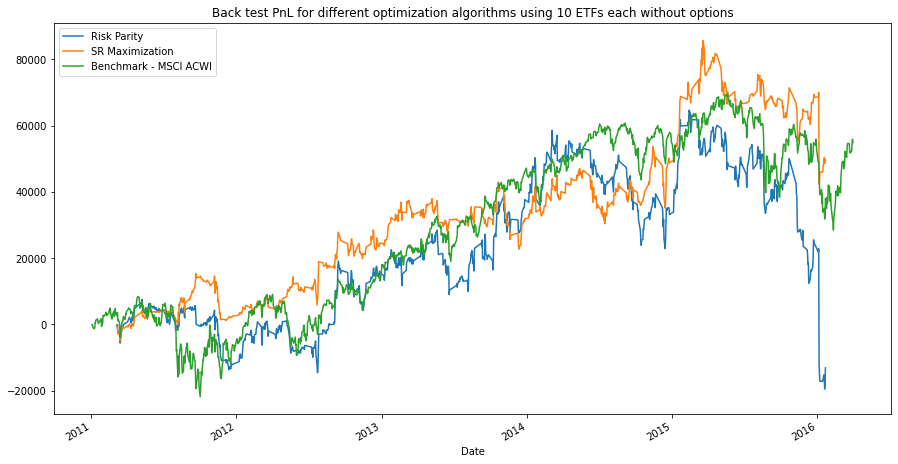

In [11]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 10 ETFs each without options')
plt.legend()
plt.show()

In [12]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

-0.1884
0.9014
-51.15%
-23.32%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -2218.100814  -2388.768002  -2559.435189  -2559.435189
2011-04-29 -1087.607710  -1503.062964  -1918.518217  -1918.518217
2011-05-31 -3016.223034  -4009.618876  -5003.014718  -5003.014718
2011-06-30 -1252.930295  -1353.559667  -1454.189039  -1454.189039
2011-07-29 -1747.714932  -2279.766093  -2811.817254  -2811.817254
2011-08-31 -5889.883889  -6959.420277  -8028.956665  -8028.956665
2011-09-30 -2736.769446  -3396.142793  -4055.516140  -4055.516140
2011-10-31 -1475.803011  -1708.172767  -1940.542522  -1940.542522
2011-11-30 -4963.862072  -5566.453177  -6169.044283  -6169.044283
2011-12-30 -1694.435508  -1902.632113  -2110.828717  -2110.828717
2012-01-31 -1527.302900  -1630.340616  -1733.378333  -1733.378333
2012-02-29 -2230.150075  -3851.220523  -5472.290971  -5472.290971
2012-03-30 -2929.762341  -4457.636759  -5985.

15 cutoff ETFs

In [13]:
opt15_bt = portfolio_optimizer(semiannual_bt)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_bt.portfolio_simulator(100000, riskfree, top15_bt, 15, VaRcutoff, 'Sharpe ratio maximization', 0)

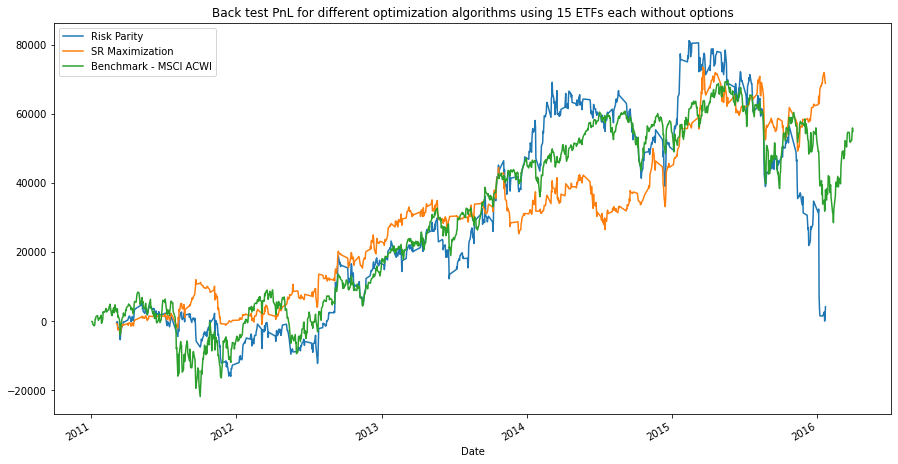

In [14]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 15 ETFs each without options')
plt.legend()
plt.show()

In [15]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

0.0625
1.7
-44.800000000000004%
-14.02%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -2039.784075  -2155.840274  -2271.896472  -2271.896472
2011-04-29  -994.835612  -1398.142749  -1801.449886  -1801.449886
2011-05-31 -2298.823542  -3059.810137  -3820.796732  -3820.796732
2011-06-30 -1272.840227  -1340.865509  -1408.890792  -1408.890792
2011-07-29 -1605.672254  -2243.487462  -2881.302670  -2881.302670
2011-08-31 -5080.610190  -6199.462652  -7318.315114  -7318.315114
2011-09-30 -3194.729632  -3314.207541  -3433.685449  -3433.685449
2011-10-31 -1589.422915  -2174.976335  -2760.529754  -2760.529754
2011-11-30 -5327.520639  -6035.257231  -6742.993823  -6742.993823
2011-12-30 -2231.519706  -2295.871409  -2360.223113  -2360.223113
2012-01-31 -1465.696817  -1480.227126  -1494.757436  -1494.757436
2012-02-29 -1611.180805  -3081.281233  -4551.381660  -4551.381660
2012-03-30 -2726.233262  -4310.32566

20 cutoff ETFs

In [16]:
opt20_bt = portfolio_optimizer(semiannual_bt)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt20_bt.portfolio_simulator(100000, riskfree, top20_bt, 20,VaRcutoff, 'Sharpe ratio maximization', 0)

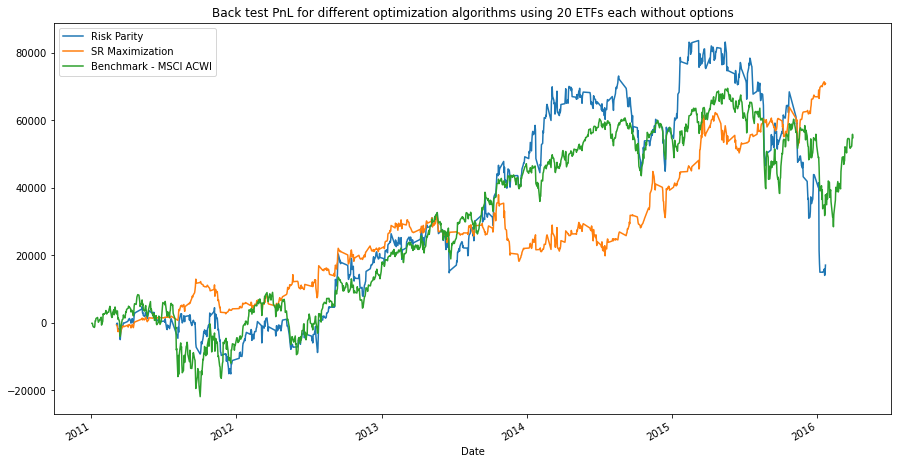

In [17]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_bt['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Back test PnL for different optimization algorithms using 20 ETFs each without options')
plt.legend()
plt.show()

In [18]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

0.2768
2.0489
-37.89%
-14.27%
                  VaR95        CVaR95         VaR99        CVaR99
Period                                                           
2011-03-31 -1820.820753  -2025.802685  -2230.784617  -2230.784617
2011-04-29  -852.737652  -1277.201159  -1701.664666  -1701.664666
2011-05-31 -2105.195419  -2662.777575  -3220.359731  -3220.359731
2011-06-30 -1592.595665  -1615.086670  -1637.577675  -1637.577675
2011-07-29 -1534.104062  -2077.960697  -2621.817333  -2621.817333
2011-08-31 -4786.903013  -5726.609393  -6666.315773  -6666.315773
2011-09-30 -3041.276602  -3622.196950  -4203.117298  -4203.117298
2011-10-31 -2048.190132  -2615.602488  -3183.014844  -3183.014844
2011-11-30 -5053.968513  -5694.604977  -6335.241441  -6335.241441
2011-12-30 -2984.422703  -3118.966775  -3253.510848  -3253.510848
2012-01-31 -1452.098795  -1489.160109  -1526.221422  -1526.221422
2012-02-29 -1602.185846  -2835.201267  -4068.216688  -4068.216688
2012-03-30 -2363.383075  -3859.960985  -5356.5

# Portfolio Performance

10 cutoff - 0 leverage options

In [19]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 0)

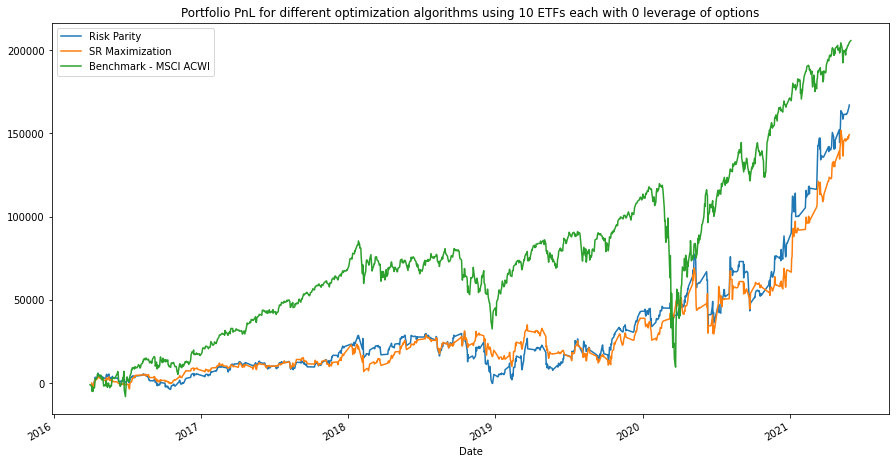

In [20]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [21]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.947
1.9367
-24.740000000000002%
-23.43%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1214.466640  -1517.899211  -1821.331781  -1821.331781
2016-05-31  -2606.796678  -3137.384489  -3667.972300  -3667.972300
2016-06-30  -1290.916021  -1957.579657  -2624.243292  -2624.243292
2016-07-29  -1171.397366  -1556.302450  -1941.207533  -1941.207533
2016-08-31  -1129.816120  -1568.513959  -2007.211799  -2007.211799
...                  ...           ...           ...           ...
2021-01-29 -13487.096722 -14300.771662 -15114.446603 -15114.446603
2021-02-26  -9589.949697  -9589.949697  -9589.949697  -9589.949697
2021-03-31 -12820.247238 -14631.617142 -16442.987046 -16442.987046
2021-04-30  -5805.907223  -7456.062581  -9106.217938  -9106.217938
2021-05-31 -10173.239938 -12463.213247 -14753.186555 -14753.186555

[62 rows x 4 columns]
                  VaR95       CVaR95         VaR99        CVaR99

10 cutoff - 10 leverage options

In [22]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 10)

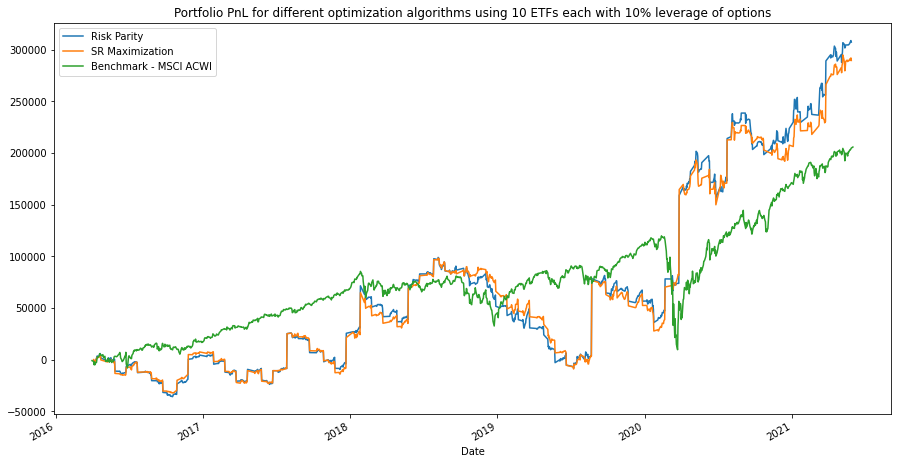

In [23]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [24]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.6624
1.6004
-53.83%
-54.120000000000005%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6674.923120  -8276.931557  -9310.905755 -10154.799215
2016-05-31  -7248.773248  -8869.395879  -9743.418460 -11215.843820
2016-06-30  -4760.038613  -6354.023995  -7641.055638  -8270.512856
2016-07-29  -4347.762278  -5552.101618  -6462.563837  -6950.611613
2016-08-31  -4772.474188  -6184.867835  -7052.038027  -8075.093199
...                  ...           ...           ...           ...
2021-01-29 -18002.698378 -20129.839278 -21526.252971 -22789.341507
2021-02-26 -14680.359307 -15832.901242 -16656.598938 -17396.636624
2021-03-31 -18888.847656 -21935.010938 -24406.969944 -25948.681742
2021-04-30 -12005.083499 -15336.821433 -18228.425718 -19573.094494
2021-05-31 -16213.525618 -20204.103590 -23594.791016 -24954.899009

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVa

10 cutoff - 20 leverage options

In [25]:
opt10_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt10_p.portfolio_simulator(100000, riskfree, top10_p, 10, VaRcutoff, 'Sharpe ratio maximization', 20)

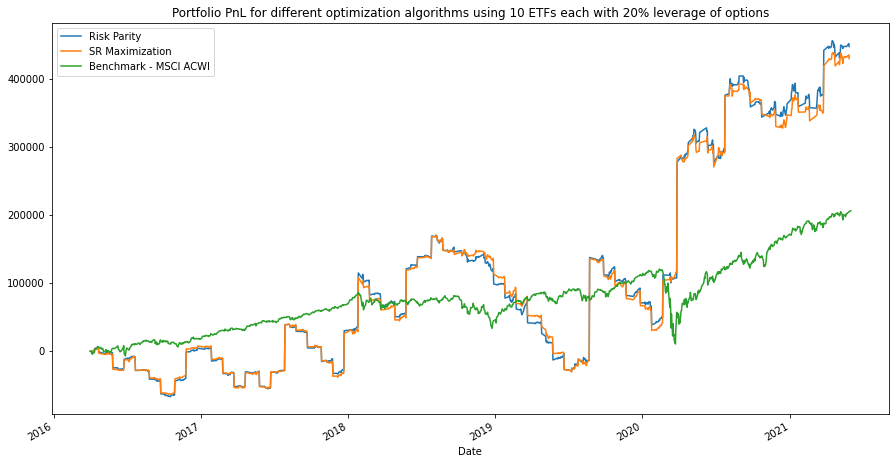

In [26]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 10 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [27]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.3193
1.2751
-74.33%
-74.6%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11489.084197 -14250.385745 -15922.575515 -18027.039710
2016-05-31 -12358.833028 -15688.008869 -17652.266750 -20624.207330
2016-06-30  -7884.189721 -10339.622963 -11967.506520 -13316.789936
2016-07-29  -7758.596198  -9641.486962 -11419.984205 -12358.428365
2016-08-31  -8415.171628 -10753.883443 -12119.463783 -14313.468483
...                  ...           ...           ...           ...
2021-01-29 -21962.200986 -24913.861726 -27041.689939 -28864.505003
2021-02-26 -20627.493683 -23792.810642 -25323.621762 -27599.893690
2021-03-31 -25109.933542 -30051.656348 -33520.170738 -36037.597312
2021-04-30 -18596.987079 -23050.704433 -26249.634334 -28471.270282
2021-05-31 -22739.900071 -28058.365940 -31977.087203 -35059.079366

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR99
Period    

15 cutoff - 0 leverage options

In [28]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 0)

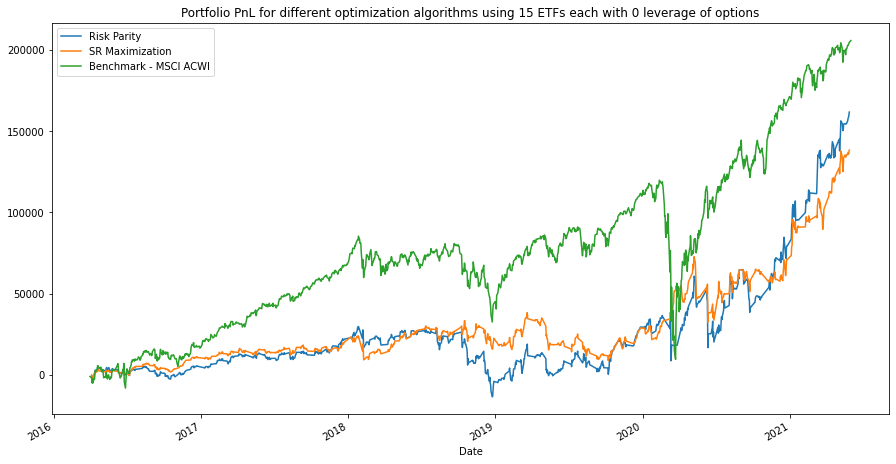

In [29]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [30]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.9178
1.9596
-33.29%
-23.39%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1178.241988  -1386.100112  -1593.958237  -1593.958237
2016-05-31  -1930.057751  -2529.933903  -3129.810056  -3129.810056
2016-06-30  -1088.886791  -1980.347421  -2871.808051  -2871.808051
2016-07-29  -1001.058486  -1245.995663  -1490.932839  -1490.932839
2016-08-31   -949.028939  -1309.004328  -1668.979717  -1668.979717
...                  ...           ...           ...           ...
2021-01-29 -12423.802915 -13429.241008 -14434.679100 -14434.679100
2021-02-26 -10103.130736 -10103.130736 -10103.130736 -10103.130736
2021-03-31 -10852.040159 -11701.497113 -12550.954067 -12550.954067
2021-04-30  -6387.256781  -7491.179726  -8595.102671  -8595.102671
2021-05-31  -9093.666509 -10583.935491 -12074.204473 -12074.204473

[62 rows x 4 columns]
                  VaR95        CVaR95         VaR99        CVaR99
Period    

15 cutoff - 10 leverage options

In [31]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 10)

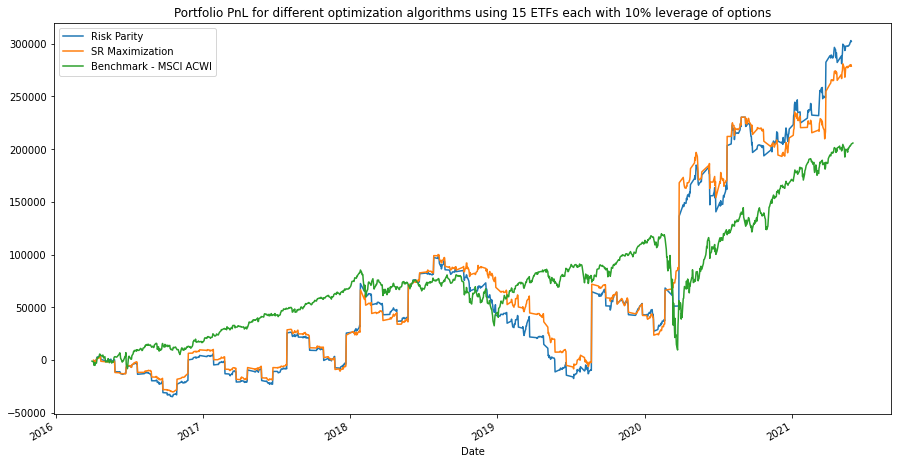

In [32]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [33]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.6382
1.5576
-58.379999999999995%
-54.2%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6638.698468  -8145.132458  -9083.532211  -9927.425671
2016-05-31  -6572.034321  -8261.945293  -9205.256216 -10677.681576
2016-06-30  -4558.009383  -6376.791759  -7888.620397  -8518.077615
2016-07-29  -4177.423398  -5241.794831  -6012.289143  -6500.336919
2016-08-31  -4591.687007  -5925.358204  -6713.805945  -7736.861117
...                  ...           ...           ...           ...
2021-01-29 -16939.404571 -19258.308624 -20846.485468 -22109.574004
2021-02-26 -15193.540346 -16346.082281 -17169.779977 -17909.817663
2021-03-31 -16920.640577 -19004.890909 -20514.936965 -22056.648763
2021-04-30 -12586.433057 -15371.938578 -17717.310451 -19061.979227
2021-05-31 -15133.952189 -18324.825834 -20915.808934 -22275.916927

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR

15 cutoff - 20 leverage options

In [34]:
opt15_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt15_p.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20)

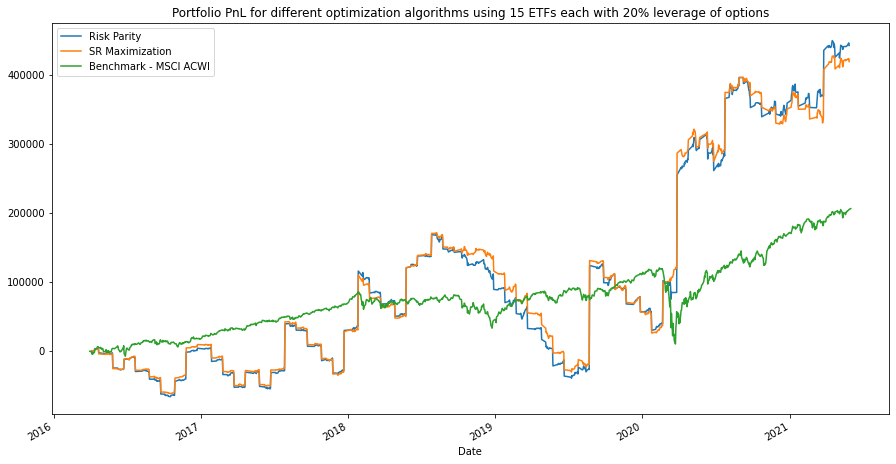

In [35]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 15 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [36]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.3044
1.2456
-77.73%
-74.51%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11452.859545 -14118.586646 -15695.201971 -17799.666166
2016-05-31 -11682.094101 -15080.558283 -17114.104506 -20086.045086
2016-06-30  -7682.160491 -10362.390727 -12215.071279 -13564.354695
2016-07-29  -7588.257318  -9331.180175 -10969.709511 -11908.153671
2016-08-31  -8234.384447 -10494.373812 -11781.231701 -13975.236401
...                  ...           ...           ...           ...
2021-01-29 -20898.907179 -24042.331072 -26361.922436 -28184.737500
2021-02-26 -21140.674722 -24305.991681 -25836.802801 -28113.074729
2021-03-31 -23141.726463 -27121.536319 -29628.137759 -32145.564333
2021-04-30 -19178.336637 -23085.821578 -25738.519067 -27960.155015
2021-05-31 -21660.326642 -26179.088184 -29298.105121 -32380.097284

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR99
Period   

20 cutoff - 0 leverage options

In [37]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 0)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 0)

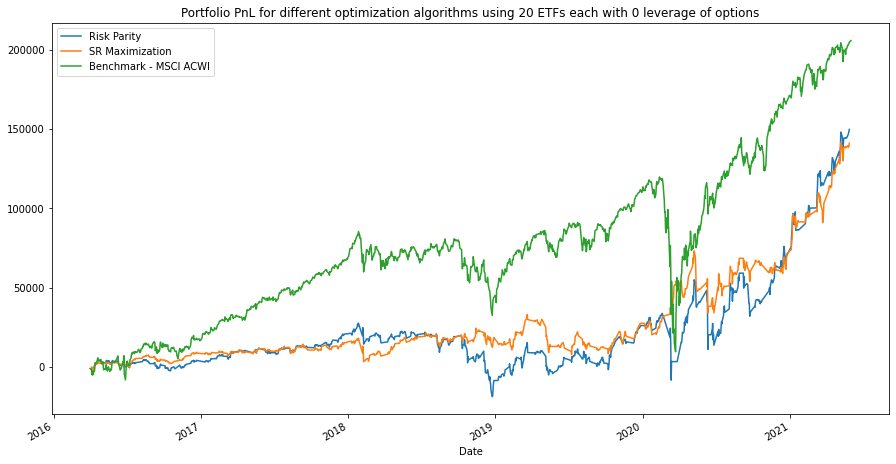

In [38]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 0 leverage of options')
plt.legend()
plt.show()

In [39]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.7568
2.0796
-36.3%
-22.73%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -1156.788984  -1275.153959  -1393.518935  -1393.518935
2016-05-31  -1627.961304  -2116.840111  -2605.718917  -2605.718917
2016-06-30  -1256.971468  -2321.448150  -3385.924831  -3385.924831
2016-07-29   -874.723345  -1063.423122  -1252.122900  -1252.122900
2016-08-31   -814.646334  -1094.085298  -1373.524262  -1373.524262
...                  ...           ...           ...           ...
2021-01-29 -13027.843303 -14070.083841 -15112.324380 -15112.324380
2021-02-26  -9291.487841  -9291.487841  -9291.487841  -9291.487841
2021-03-31  -9817.738918 -10369.454292 -10921.169667 -10921.169667
2021-04-30  -5651.081226  -6670.097884  -7689.114542  -7689.114542
2021-05-31  -8800.976373 -10566.409117 -12331.841860 -12331.841860

[62 rows x 4 columns]
                  VaR95        CVaR95         VaR99        CVaR99
Period     

20 cutoff - 10 leverage options

In [40]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 10)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 10)

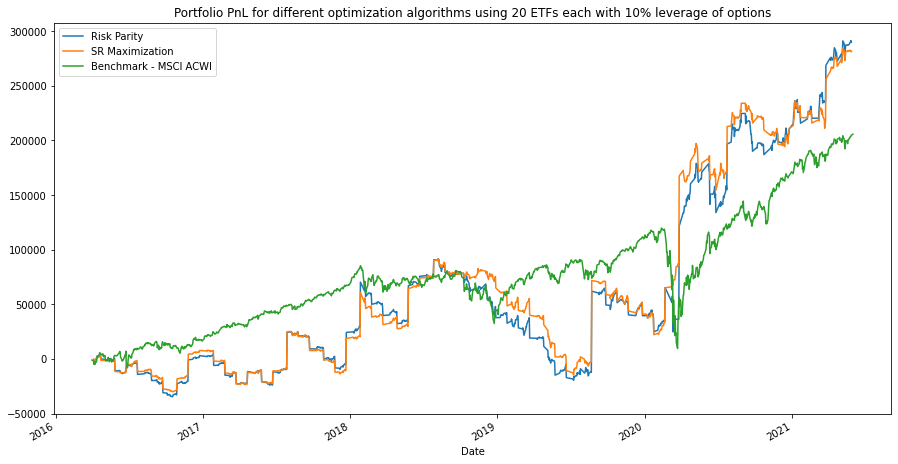

In [41]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 10% leverage of options')
plt.legend()
plt.show()

In [42]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.5697
1.5795
-58.050000000000004%
-55.42%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29  -6617.245464  -8034.186305  -8883.092909  -9726.986369
2016-05-31  -6269.937874  -7848.851501  -8681.165077 -10153.590437
2016-06-30  -4726.094060  -6717.892488  -8402.737177  -9032.194395
2016-07-29  -4051.088257  -5059.222290  -5773.479204  -6261.526980
2016-08-31  -4457.304402  -5710.439174  -6418.350490  -7441.405662
...                  ...           ...           ...           ...
2021-01-29 -17543.444959 -19899.151457 -21524.130748 -22787.219284
2021-02-26 -14381.897451 -15534.439386 -16358.137082 -17098.174768
2021-03-31 -15886.339336 -17672.848088 -18885.152565 -20426.864363
2021-04-30 -11850.257502 -14550.856736 -16811.322322 -18155.991098
2021-05-31 -14841.262053 -18307.299460 -21173.446321 -22533.554314

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVa

20 cutoff - 20 leverage options

In [75]:
opt20_p = portfolio_optimizer(semiannual_p)
# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Risk parity', 20)
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr= opt20_p.portfolio_simulator(100000, riskfree, top20_p, 20, VaRcutoff, 'Sharpe ratio maximization', 20)

In [76]:
PnL_sr.cumsum().to_excel("Portfolio_PnL.xlsx")
benchmark_pnl_p['PnL'].cumsum().to_excel("Benchmark_PnL.xlsx")

In [77]:
temp = dollar_full_portfolio_sr.copy()

In [82]:
pd.DataFrame([temp.columns, np.count_nonzero(temp,axis=0)]).to_csv("counts.csv")

In [66]:
temp

,USA_EWZ,USA_EZA,USA_EPU,USA_TUR,USA_ERUS,USA_ICOL,USA_EPOL,USA_EWM,USA_EWY,USA_INDA,...,CAN_ETHI.TO,CAN_HEWB.TO,CAN_HURA.TO,USA_IHAK,CAN_HLPR.TO,CAN_HSAV.TO,CAN_HULC.TO,CAN_HXCN.TO,USA_KWT,CAN_HXEM.TO
Date,,,,,,,,,,,,,,,,,,,,,
2016-04-04,-3.850331e-15,-4.447191e-16,-0.005719,0.001857,-2.068961e-15,NaN,0.000460,NaN,-6.377557e-17,-0.000177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-05,-4.809050e-16,-2.784796e-15,-0.000778,-0.002755,-1.841255e-16,NaN,-0.012414,NaN,-1.681364e-16,-0.001879,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-06,-6.567652e-16,5.264138e-16,-0.004159,-0.000093,2.905899e-15,NaN,0.002132,NaN,1.597941e-16,0.000688,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-07,-6.275600e-16,-1.882758e-15,-0.009623,-0.004249,-1.698153e-15,NaN,-0.013906,NaN,-1.380840e-16,-0.002155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-04-08,4.921195e-15,2.356347e-15,0.009813,0.003208,2.550473e-15,NaN,0.005119,NaN,1.095033e-16,0.000552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-24,3.652028e-15,NaN,NaN,NaN,NaN,NaN,0.000212,NaN,NaN,NaN,...,NaN,NaN,NaN,3.664649e-15,NaN,NaN,NaN,NaN,-0.001476,NaN
2021-05-25,-2.815248e-15,NaN,NaN,NaN,NaN,NaN,0.000314,NaN,NaN,NaN,...,NaN,NaN,NaN,-1.264753e-15,NaN,NaN,NaN,NaN,-0.001212,NaN
2021-05-26,3.022387e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5.077874e-15,NaN,NaN,NaN,NaN,-0.002971,NaN


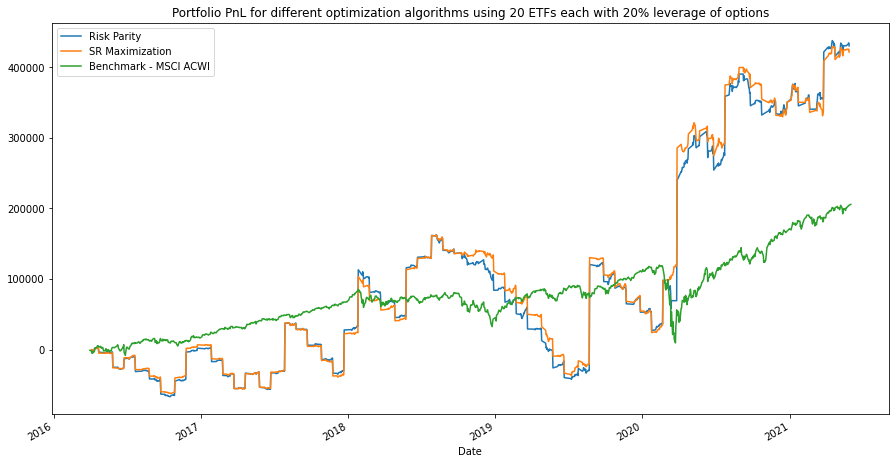

In [44]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')
benchmark_pnl_p['PnL'].cumsum().plot(figsize=(15,8), label='Benchmark - MSCI ACWI')

plt.title('Portfolio PnL for different optimization algorithms using 20 ETFs each with 20% leverage of options')
plt.legend()
plt.show()

In [45]:
print(sharpe_rp)
print(sharpe_sr)
print(max_drawdown_rp)
print(max_drawdown_sr)
print(overallrisk_rp)
print(overallrisk_sr)

1.2682
1.2546
-77.97%
-76.07000000000001%
                   VaR95        CVaR95         VaR99        CVaR99
Period                                                            
2016-04-29 -11431.406541 -14007.640493 -15494.762669 -17599.226864
2016-05-31 -11379.997654 -14667.464491 -16590.013367 -19561.953947
2016-06-30  -7850.245168 -10703.491456 -12729.188059 -14078.471475
2016-07-29  -7461.922177  -9148.607634 -10730.899572 -11669.343732
2016-08-31  -8100.001842 -10279.454782 -11485.776246 -13679.780946
...                  ...           ...           ...           ...
2021-01-29 -21502.947567 -24683.173905 -27039.567716 -28862.382780
2021-02-26 -20329.031827 -23494.348786 -25025.159906 -27301.431834
2021-03-31 -22107.425222 -25789.493498 -27998.353359 -30515.779933
2021-04-30 -18442.161082 -22264.739736 -24832.530938 -27054.166886
2021-05-31 -21367.636506 -26161.561810 -29555.742508 -32637.734671

[62 rows x 4 columns]
                   VaR95        CVaR95         VaR99        CVaR

# Scenario Analysis

As the scenario testing, three scenarios will be tested:
1. the entire market will crash by half with probability 2% in a single day;
2. each ETFs will randomly crash by a half with probability 5% in a single day.
3. each ETFs will crush by moving average

In [46]:
# Market crush scenario
opt_sa1 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20, scenario='Market crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='Market crash')

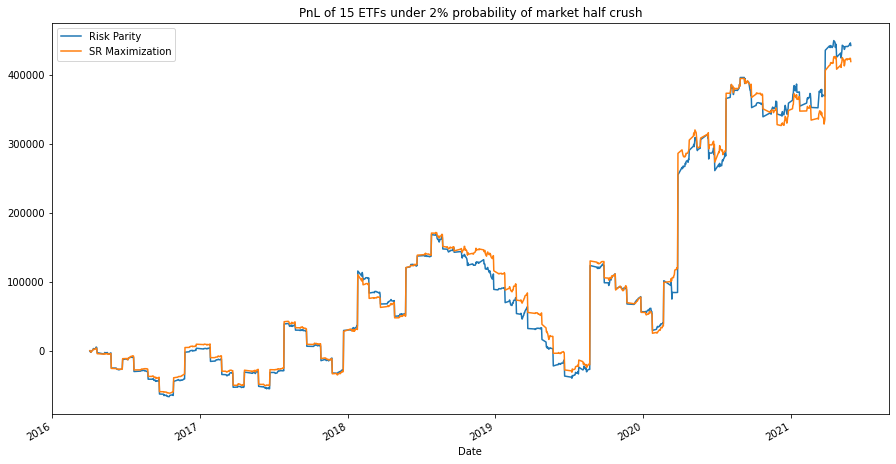

In [47]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 2% probability of market half crush')
plt.legend()
plt.show()

In [48]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859545,-14118.586646,-15695.201971,-17799.666166
2016-05-31,-11682.094359,-15080.558545,-17114.104770,-20086.045350
2016-06-30,-7682.160509,-10362.390768,-12215.071343,-13564.354759
2016-07-29,-7588.257344,-9331.180296,-10969.709728,-11908.153888
2016-08-31,-8234.384445,-10494.373810,-11781.231698,-13975.236398
...,...,...,...,...
2021-01-29,-20898.907818,-24042.331550,-26361.922754,-28184.737818
2021-02-26,-21140.674878,-24305.991837,-25836.802957,-28113.074885
2021-03-31,-23141.728075,-27121.538210,-29628.139929,-32145.566503


In [49]:
overallrisk_rp.sum(axis=1)

Period
2016-04-29    -59066.314328
2016-05-31    -63962.803024
2016-06-30    -43823.977380
2016-07-29    -39797.301257
2016-08-31    -44485.226352
                  ...      
2021-01-29    -99487.899941
2021-02-26    -99396.544555
2021-03-31   -112036.972717
2021-04-30    -95962.832889
2021-05-31   -109517.619208
Length: 62, dtype: float64

In [50]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -74.69%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11336.408134,-14168.871953,-15912.223995,-18016.688190
2016-05-31,-11162.490487,-14501.159674,-16474.910901,-19446.851481
2016-06-30,-7000.218855,-9002.336981,-10176.905422,-11526.188838
2016-07-29,-7553.098201,-9724.890951,-11792.290180,-12730.734340
2016-08-31,-8120.027846,-10269.000704,-11444.842087,-13638.846787
...,...,...,...,...
2021-01-29,-17931.042790,-21628.980080,-24503.084842,-26325.899906
2021-02-26,-18565.234632,-21730.551591,-23261.362711,-25537.634639
2021-03-31,-17781.926299,-22253.506272,-25251.877829,-27769.304403


In [51]:
# Individual ETF random crush scenario
opt_sa2 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity', 20, scenario='Random ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='Random ETF crash')


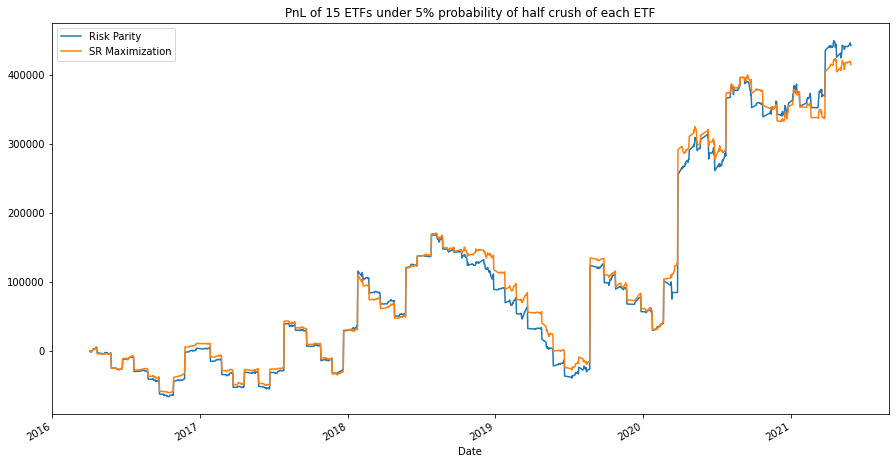

In [52]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of half crush of each ETF')
plt.legend()
plt.show()

In [53]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859685,-14118.586717,-15695.201973,-17799.666168
2016-05-31,-11682.094074,-15080.558142,-17114.104249,-20086.044829
2016-06-30,-7682.160467,-10362.390698,-12215.071246,-13564.354662
2016-07-29,-7588.257134,-9331.180053,-10969.709452,-11908.153612
2016-08-31,-8234.384396,-10494.373902,-11781.231932,-13975.236632
...,...,...,...,...
2021-01-29,-20898.907660,-24042.330870,-26361.921551,-28184.736615
2021-02-26,-21140.673565,-24305.990524,-25836.801644,-28113.073572
2021-03-31,-23141.725333,-27121.535515,-29628.137281,-32145.563855


In [54]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -73.47%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11360.863120,-14214.934886,-15979.894874,-18084.359069
2016-05-31,-10851.873360,-14386.496591,-16556.201863,-19528.142443
2016-06-30,-7013.831201,-9105.055489,-10368.730093,-11718.013509
2016-07-29,-7546.636987,-9689.031361,-11727.032214,-12665.476374
2016-08-31,-8067.056996,-10206.441120,-11372.693769,-13566.698469
...,...,...,...,...
2021-01-29,-17619.354219,-21299.407185,-24155.627624,-25978.442688
2021-02-26,-17403.670987,-20568.987946,-22099.799066,-24376.070994
2021-03-31,-20189.697301,-24236.344804,-26809.783890,-29327.210464


In [55]:
# MV crush scenario
opt_sa1 = portfolio_optimizer(semiannual_p)

# Risk parity
dollar_full_portfolio_rp, PnL_rp,usdrisk_rp,cadrisk_rp,overallrisk_rp, max_drawdown_rp,sharpe_rp,_finalweights_rp = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Risk parity',20, scenario='MV ETF crash')
# Sharpe Ratio Maximization
dollar_full_portfolio_sr, PnL_sr,usdrisk_sr,cadrisk_sr,overallrisk_sr, max_drawdown_sr,sharpe_sr,_finalweights_sr = opt_sa1.portfolio_simulator(100000, riskfree, top15_p, 15, VaRcutoff, 'Sharpe ratio maximization', 20, scenario='MV ETF crash')

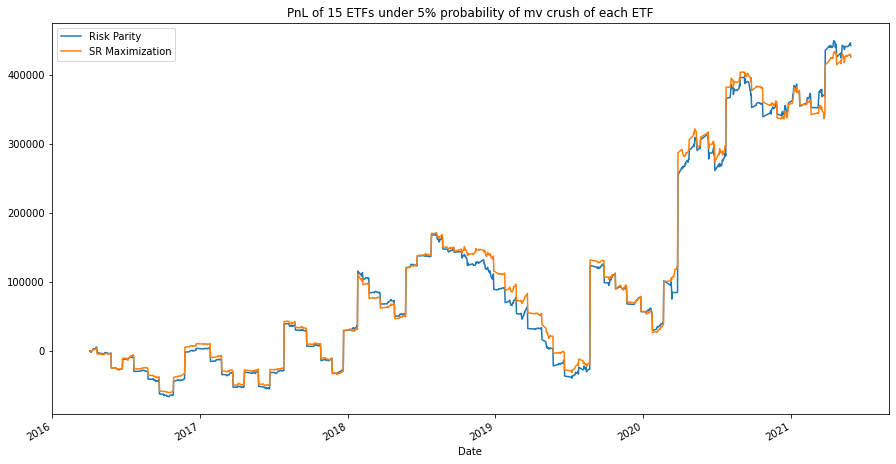

In [56]:
PnL_rp.cumsum().plot(figsize=(15,8), label='Risk Parity')
PnL_sr.cumsum().plot(figsize=(15,8), label='SR Maximization')

plt.title('PnL of 15 ETFs under 5% probability of mv crush of each ETF')
plt.legend()
plt.show()

In [57]:
print(f'Max drawdown for Risk parity: {max_drawdown_rp}')
overallrisk_rp

Max drawdown for Risk parity: -77.73%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11452.859650,-14118.586684,-15695.201940,-17799.666135
2016-05-31,-11682.094105,-15080.558289,-17114.104513,-20086.045093
2016-06-30,-7682.160493,-10362.390731,-12215.071285,-13564.354701
2016-07-29,-7588.257343,-9331.180198,-10969.709532,-11908.153692
2016-08-31,-8234.384449,-10494.373815,-11781.231704,-13975.236404
...,...,...,...,...
2021-01-29,-20898.910164,-24042.334829,-26361.926967,-28184.742031
2021-02-26,-21140.674727,-24305.991686,-25836.802806,-28113.074734
2021-03-31,-23141.726866,-27121.536592,-29628.137902,-32145.564476


In [58]:
print(f'Max drawdown for Risk parity: {max_drawdown_sr}')
overallrisk_sr

Max drawdown for Risk parity: -74.8%


,VaR95,CVaR95,VaR99,CVaR99
Period,,,,
2016-04-29,-11357.368148,-14168.231543,-15889.983160,-17994.447355
2016-05-31,-10862.319842,-14228.353815,-16229.469828,-19201.410408
2016-06-30,-6978.882793,-9029.467562,-10252.502648,-11601.786064
2016-07-29,-7780.942153,-10138.611778,-12391.887884,-13330.332044
2016-08-31,-8126.452621,-10277.341806,-11455.099515,-13649.104215
...,...,...,...,...
2021-01-29,-18479.421906,-21883.659183,-24464.063933,-26286.878997
2021-02-26,-17874.158923,-21039.475882,-22570.287002,-24846.558930
2021-03-31,-17831.461308,-22315.137929,-25325.606134,-27843.032708
